In [10]:
import torch 
from dataset import Pic_to_Pic_dataset
from models import UNET, U2NET
from torch.utils.data import DataLoader
from loss import SSIM_DICE_BCE, DiceScore
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd 
from PIL import Image 
from torchvision.transforms import ToTensor
import os 
from tqdm import tqdm 
import cv2

In [16]:
model = UNET().cuda()
ckpt = torch.load('./ckpts/quantum_noise/56/best_unet.pth') 
model.load_state_dict(ckpt['model_state'])
dice_score = DiceScore()
print(model)


UNET(
  (ch): DoubleConv(
    (net): Sequential(
      (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): PReLU(num_parameters=64)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): PReLU(num_parameters=64)
    )
  )
  (down1): DownBlock(
    (net): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): DoubleConv(
        (net): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): PReLU(num_parameters=128)
          (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (4): BatchNorm2d(128, eps=1e-05, momentum

In [2]:
!mkdir ../../shivagit/tennis-detection



  0%|          | 0/64 [00:00<?, ?it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats

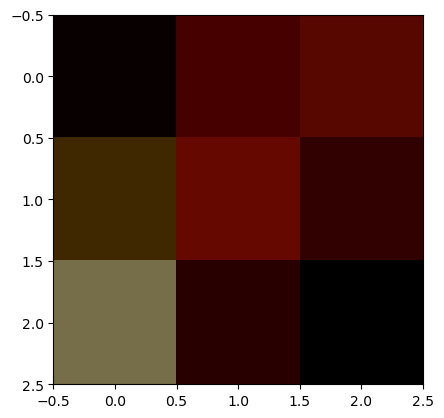

In [66]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.animation as animation

img = model.features[0].weight.detach().cpu()#[] # some array of images
frames = [] # for storing the generated images
fig = plt.figure()
for i in tqdm(range(64)):
    frames.append([plt.imshow(img[i], cmap='gray',animated=True)])

ani = animation.ArtistAnimation(fig, frames, interval=100, blit=True,
                                repeat_delay=1000)
ani.save('movie.mp4')
ani.resume()

tensor(0.6982)
tensor(0.6469)
tensor(0.4664)
tensor(0.4164)
tensor(0.2995)
tensor(0.5398)
tensor(0.4204)
tensor(1.1256)
tensor(0.3859)
tensor(0.4426)
tensor(0.5166)
tensor(0.6047)
tensor(0.3934)
tensor(0.5565)
tensor(0.4584)
tensor(0.5994)
tensor(0.3209)
tensor(0.5181)
tensor(0.6300)
tensor(1.0234)
tensor(0.6003)
tensor(0.5088)
tensor(0.5105)
tensor(2.3801)
tensor(0.3565)
tensor(0.5800)
tensor(0.4702)
tensor(0.5946)
tensor(0.6765)
tensor(0.5127)
tensor(0.4122)
tensor(0.5774)
tensor(0.5378)
tensor(0.5151)
tensor(0.6242)
tensor(0.5184)
tensor(0.6400)
tensor(0.6214)
tensor(0.5409)
tensor(0.3201)
tensor(0.4605)
tensor(0.4426)
tensor(0.6384)
tensor(0.5572)
tensor(0.3564)
tensor(0.5262)
tensor(0.7568)
tensor(0.4035)
tensor(0.4195)
tensor(0.6651)
tensor(0.4504)
tensor(0.4812)
tensor(0.6076)
tensor(0.5209)
tensor(0.6405)
tensor(0.4833)
tensor(0.6572)
tensor(0.5359)
tensor(0.4173)
tensor(0.2847)
tensor(0.3907)
tensor(0.2215)
tensor(0.4894)
tensor(0.3511)


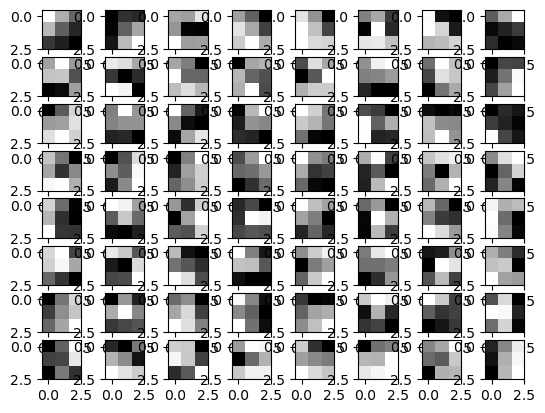

In [34]:
weights = model.ch.net[0].weight.detach().cpu()

for idx, weight in enumerate(weights): 
    plt.subplot(8, 8, idx+1)
    plt.imshow(weight.permute(1, 2, 0), cmap='gray')
    

In [11]:
model = U2NET().cuda()
ckpt = torch.load('./ckpts/quantum_noise/57/best_u2net.pth') 
model.load_state_dict(ckpt['model_state'])
dice_score = DiceScore()

In [12]:
df = pd.read_csv('/home/shivac/qml-data/csv_files/val_10_org.csv') 
patient_ids = np.unique(df.patient_id)
patient_id = np.random.choice(patient_ids, 1)[0]
df = df[df.patient_id == patient_id].sort_values('idx')
df.reset_index(inplace=True)
os.makedirs('plots/{}'.format(patient_id), exist_ok=True)
model.eval()
for i in tqdm(range(len(df))): 
    img_path = '/home/shivac/qml-data/' + df.loc[i].img_path
    mask_path = '/home/shivac/qml-data/' + df.loc[i].mask_path
    img = Image.open(img_path).convert('L')
    mask = Image.open(mask_path) 
    mask = ToTensor()(mask).unsqueeze(0)
    img = ToTensor()(img).unsqueeze(0)
    logits = model(img.cuda())
    dice = round(dice_score(mask.cuda(), logits).item(), 2)

    plt.figure(figsize=(10, 6), facecolor='gray')
    plt.axis('off')
    plt.title('Depth: ' + str(i) + ' dice_score: ' + str(dice))
    plt.subplot(1,3,1)
    plt.title('img')
    plt.axis('off')
    plt.imshow(img[0].permute(1,2,0), cmap='gray')
    plt.subplot(1,3,2)
    plt.title('mask')
    plt.axis('off')
    plt.imshow(mask[0].permute(1,2,0), cmap='gray')
    plt.subplot(1,3,3)
    plt.title('logits')
    plt.axis('off')
    plt.imshow(logits[0].detach().cpu().permute(1,2,0), cmap='gray')
    # plt.tight_layout() 
    plt.savefig('plots/{}/{}.png'.format(patient_id, i))
    plt.clf() 
    plt.close()
    
    


  0%|          | 0/301 [00:00<?, ?it/s]/home/shivac/anaconda3/lib/python3.11/site-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,
100%|██████████| 301/301 [01:04<00:00,  4.70it/s]


In [13]:
def imgs_to_vid(path): 
    imgs = os.listdir(path)
    imgs = [os.path.join(path, img) for img in imgs if img.endswith('.png')]
    imgs = sorted(imgs, key=lambda x: int(x.split('/')[-1].split('.')[0]))
    img = cv2.imread(imgs[6])
    os.makedirs('{}/'.format(path), exist_ok=True)
    video = cv2.VideoWriter('{}/vid.mp4'.format(path), cv2.VideoWriter_fourcc(*'mp4v'), 10, (img.shape[1], img.shape[0]))

    for img_path in tqdm(imgs): 
        if not img_path.endswith('.png'): 
            continue
        img = cv2.imread(img_path)
        video.write(img)       
    video.release()
    os.system('rm ./plots/{}/*.png'.format(patient_id))

imgs_to_vid('./plots/{}/'.format(patient_id))

  0%|          | 0/301 [00:00<?, ?it/s]

100%|██████████| 301/301 [00:03<00:00, 99.04it/s] 


In [15]:
patient_id

'MEDVID0083_M_20211130_113657_0001_IMAGES'